## Reconstruct multi-channel BrainWeb simulations and compute NMI

This notebook applies the forward model of UniRes to 'ideal' MR images from the BrainWeb simulator [1], generating degraded, low-resolution (LR) images as x[i] = A[i]y[i] + n, i={0, 1, 2}. The LR images are then reconstructed using the UniRes super-resolution algorithm. The normalized mutual information (NMI) is computed between the reconstructions.

1. https://brainweb.bic.mni.mcgill.ca/

### Requirements
```sh
pip install scikit-image
```


In [1]:
from nitorch.plot import show_slices
from nitorch import io
from nitorch.spatial import affine_matrix_classic
from numpy.random import random_sample as rnd
import torch
from unires._project import (_proj_apply, _proj_info)
from unires.struct import settings
from unires.run import preproc
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_mutual_information as nmi

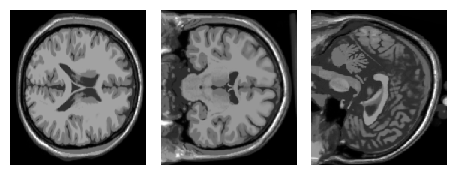

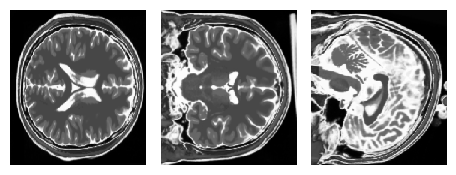

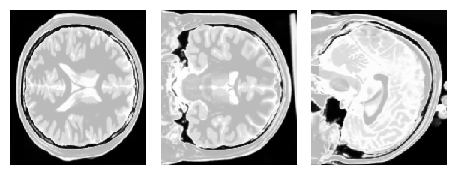

In [2]:
# Load images
pths = [
    "../data/t1_icbm_normal_1mm_pn0_rf0.nii.gz",
    "../data/t2_icbm_normal_1mm_pn0_rf0.nii.gz",
    "../data/pd_icbm_normal_1mm_pn0_rf0.nii.gz",
]
nii_y, y = [], []
for pth in pths:  nii_y.append(io.map(pth))
for nii in nii_y:  y.append(nii.fdata())

# Visualise
figsize = (7/1.5, 3/1.5)
_ = [show_slices(y[i], figsize=figsize, fig_num=i) for i in range(len(y))]

dim_y[0]=tensor([181., 217., 181.], dtype=torch.float64)
dim_x[0]=tensor([ 45., 217., 181.], dtype=torch.float64)
dim_y[1]=tensor([181., 217., 181.], dtype=torch.float64)
dim_x[1]=tensor([181.,  54., 181.], dtype=torch.float64)
dim_y[2]=tensor([181., 217., 181.], dtype=torch.float64)
dim_x[2]=tensor([181., 217.,  45.], dtype=torch.float64)


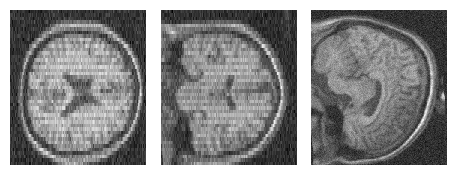

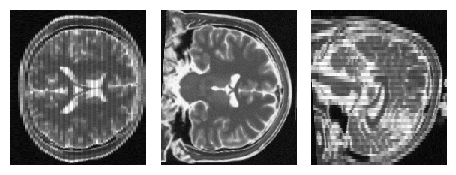

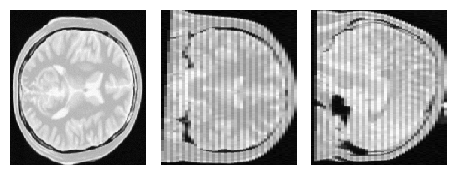

In [3]:
# Apply UniRes forward model to BrainWeb MRIs (y[i] = A[i]x[i] + n)

# Parameters
# https://github.com/brudfors/UniRes/blob/master/unires/struct.py#L57
vx_ts = 4  # thick-slice voxel size
prof_ip = 0  # (0=rect|1=tri|2=gauss)
prof_tp = 0  # (0=rect|1=tri|2=gauss)
s_gap = 0.0  # slice gap
device = "cuda"  # GPU or CPU
eo_scl = 0.1  # even/odd slice scaling
std_noise = 75  # std of Gaussian noise
rigid_t = 10.0  # amount of random translation
rigid_r = 0.2  # amount of random rotation

x, mat_x, dim_y = [], [], []
for i in range(len(y)):

    # Set output field of view
    vx_scl = torch.ones(3)
    vx_scl[i] = vx_ts
    mat_y = nii_y[i].affine
    dim_y.append(torch.as_tensor(y[i].shape, dtype=mat_y.dtype))
    scl = torch.as_tensor(torch.cat((vx_scl, torch.ones(1))), dtype=mat_y.dtype)
    mat_scl = torch.diag(scl)
    mat_x.append(mat_y.mm(mat_scl))
    dim_x = mat_scl[:3, :3].inverse().mm(dim_y[i][:, None]).floor().squeeze()
    print(f"dim_y[{i}]={dim_y[i]}")
    print(f"dim_x[{i}]={dim_x}")

    # Set device
    mat_x[i] = mat_x[i].to(device)
    mat_y = mat_y.to(device)
    dim_y[i] = dim_y[i].to(device)
    dim_x = dim_x.to(device)
    y[i] = y[i].to(device)

    # Random rigid matrix
    rigid = affine_matrix_classic(
        [
            rigid_t*rnd() - rigid_t/2, rigid_t*rnd() - rigid_t/2, rigid_t*rnd() - rigid_t/2, 
            rigid_r*rnd() - rigid_r/2, rigid_r*rnd() - rigid_r/2, rigid_r*rnd() - rigid_r/2,
        ],
    ).to(device)

    # Create projection operator
    po = _proj_info(
        dim_y[i], mat_y, dim_x, mat_x[i], 
        rigid=rigid, prof_ip=prof_ip, prof_tp=prof_tp, 
        gap=s_gap, device=device, scl=eo_scl
    )
    A = lambda y: _proj_apply("A", y[None, None, ...], po)[0, 0, ...]
    n = std_noise*torch.randn(dim_x.cpu().type(torch.int).tolist(), device=device)

    # Apply forward model A
    x.append(A(y[i]) + n)

# Visualise
_ = [show_slices(x[i], figsize=figsize, fig_num=i) for i in range(len(x))]

In [4]:
# Run UniRes with unified super-resolution

# Set input data
data = []
for i in range(len(x)):
    data.append([[x[i], mat_x[i]]])

# Settings
s = settings()
s.write_out = False
s.pow = dim_y[i].cpu().type(torch.int).tolist()
# Run algorithm
y_hat, _, _ = preproc(data, sett=s)


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

28/04/2023 11:53:12 | GPU: NVIDIA RTX A6000, CUDA: True, PyTorch: 2.0.0

Input
c=0, n=0 | fname=None
c=1, n=0 | fname=None
c=2, n=0 | fname=None

Estimating model hyper-parameters... completed in 0.21517 seconds:
c=0 | tau= 0.0001571 | sd=     79.77 | mu=     448.8 | ct=False 
c=1 | tau= 0.0001538 | sd=     80.64 | mu=      1954 | ct=False 
c=2 | tau= 9.519e-05 | sd=     102.5 | mu=      4395 | ct=False 

Performing multi-channel (N=3) alignment...completed in 3.43716 seconds.

Mean space | dim=(181, 217, 181), vx=(1.0, 1.0, 1.0)

ADMM step-size=0.6367

Starting super-resolution (update_rigid=True, update_scaling=True) 
 | C=3 | N=3 | device=cuda | max_iter=512 | tol=0.0001 | sched_num=3
  0 - Convergence ( 1.4 s)  | nlyx =  5.135e+07, nlxy =  3.401e+07, nly =  1.733e+07, gain =        inf
  1 - Convergence ( 1.5 s)  | nlyx = 

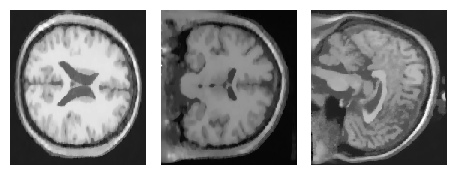

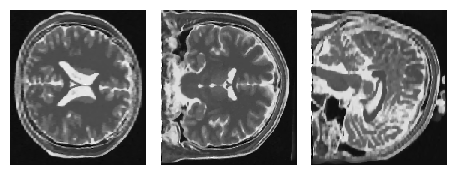

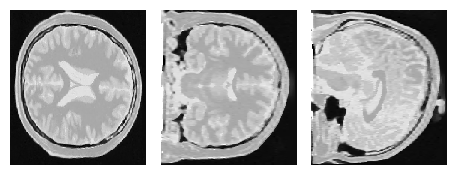

In [5]:
# Visualise results
_ = [show_slices(y_hat[..., i], figsize=figsize, fig_num=i) for i in range(len(x))]

In [6]:
# Compute NMI
i0, i1 = 0, 1
nmi_sr = nmi(y_hat[..., i0].cpu().numpy(), y_hat[..., i1].cpu().numpy()) - 1
print(f"NMI(y[{i0}], y_hat[{i1}])={nmi_sr}")
i0, i1 = 0, 2
nmi_sr = nmi(y_hat[..., i0].cpu().numpy(), y_hat[..., i1].cpu().numpy()) - 1
print(f"NMI(y[{i0}], y_hat[{i1}])={nmi_sr}")
i0, i1 = 1, 2
nmi_sr = nmi(y_hat[..., i0].cpu().numpy(), y_hat[..., i1].cpu().numpy()) - 1
print(f"NMI(y[{i0}], y_hat[{i1}])={nmi_sr}")

NMI(y[0], y_hat[1])=0.20385733034538345
NMI(y[0], y_hat[2])=0.19270995232351695
NMI(y[1], y_hat[2])=0.1864518115182019
